In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2

# shrink

In [2]:
def shrink_quads_numpy(reshaped_quads, ref_lengths, scale=0.3):
    """
    convert quads into rbox, see fig4 in EAST paper
    :param reshaped_quads: ndarray, shape = (box nums, 4=(clockwise from top-left), 2=(x,y))
    :param ref_lengths: ndarray, shape = (box nums, 4)
    :param scale: int, shrink scale
    :return: rboxes: ndarray, shape = (box nums, 4=(clockwise from top-left), 2=(x, y))
    """
    assert reshaped_quads.shape[-2:] == (4, 2), "reshaped_quads' shape must be (box nums, 4, 2)"

    def _shrink_h(quad, ref_len):
        """
        :param quad: ndarray, shape = (4, 2)
        :param ref_len: ndarray, shape = (4,)
        """
        
        # get angle
        adj_quad = np.roll(quad[::-1], 2, axis=0) # adjacent points
        # shape = (4,)
        angles = np.arctan2(adj_quad[:, 1] - quad[:, 1], adj_quad[:, 0] - quad[:, 0])

        # shape = (4,2)
        trigonometric = np.array([np.cos(angles),
                                  np.sin(angles)]).T

        quad += np.expand_dims(ref_len, axis=-1) * trigonometric * scale
        """
        ## p0, p1
        theta = np.arctan2((quad[1][1] - quad[0][1]), (quad[1][0] - quad[0][0]))
        quad[0][0] += scale * ref_len[0] * np.cos(theta)
        quad[0][1] += scale * ref_len[0] * np.sin(theta)
        quad[1][0] -= scale * ref_len[1] * np.cos(theta)
        quad[1][1] -= scale * ref_len[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((quad[2][1] - quad[3][1]), (quad[2][0] - quad[3][0]))
        quad[3][0] += scale * ref_len[3] * np.cos(theta)
        quad[3][1] += scale * ref_len[3] * np.sin(theta)
        quad[2][0] -= scale * ref_len[2] * np.cos(theta)
        quad[2][1] -= scale * ref_len[2] * np.sin(theta)
        """
        
        return quad

    def _shrink_v(quad, ref_len):
        """
        :param quad: ndarray, shape = (4, 2)
        :param ref_len: ndarray, shape = (4,)
        """
        
        
        # get angle
        adj_quad = quad[::-1] # adjacent points
        # shape = (4,)
        angles = np.arctan2(adj_quad[:, 0] - quad[:, 0], adj_quad[:, 1] - quad[:, 1])

        # shape = (4,2)
        trigonometric = np.array([np.sin(angles),
                                  np.cos(angles)]).T

        quad += np.expand_dims(ref_len, axis=-1) * trigonometric * scale
        """
        ## p0, p3
        # print quad
        theta = np.arctan2((quad[3][0] - quad[0][0]), (quad[3][1] - quad[0][1]))
        quad[0][0] += scale * ref_len[0] * np.sin(theta)
        quad[0][1] += scale * ref_len[0] * np.cos(theta)
        quad[3][0] -= scale * ref_len[3] * np.sin(theta)
        quad[3][1] -= scale * ref_len[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((quad[2][0] - quad[1][0]), (quad[2][1] - quad[1][1]))
        quad[1][0] += scale * ref_len[1] * np.sin(theta)
        quad[1][1] += scale * ref_len[1] * np.cos(theta)
        quad[2][0] -= scale * ref_len[2] * np.sin(theta)
        quad[2][1] -= scale * ref_len[2] * np.cos(theta)
        """

        return quad

    def _shrink(quad, ref_len, horizontal_first):
        """
        :param quad: ndarray, shape = (4, 2)
        :param ref_len: ndarray, shape = (4,)
        :param horizontal_first: boolean, if True, horizontal edges will be shrunk first, otherwise vertical ones will be shrunk first
        :return:
        """
        if horizontal_first:
            quad = _shrink_h(quad, ref_len)
            quad = _shrink_v(quad, ref_len)
        else:
            quad = _shrink_v(quad, ref_len)
            quad = _shrink_h(quad, ref_len)

        return quad

    box_nums = reshaped_quads.shape[0]

    # lengths, clockwise from horizontal top edge
    # shape = (box nums, 4)
    lengths = np.linalg.norm(reshaped_quads - np.roll(reshaped_quads, 1, axis=1), axis=-1)

    h_lens, v_lens = np.mean(lengths[:, ::2], axis=-1), np.mean(lengths[:, 1::2], axis=-1)
    horizontal_firsts = h_lens > v_lens
    
    shrinked_quads = np.array([_shrink(reshaped_quads[b], ref_lengths[b], horizontal_firsts[b]) for b in range(box_nums)])
    return shrinked_quads

In [3]:
quads = np.array([[23, 23], [64, 14], [80, 92], [48, 91]], dtype=np.float)

reshaped_quads = quads.reshape((-1, 4, 2))

ref_lengths = np.minimum(np.linalg.norm(reshaped_quads - np.roll(reshaped_quads, 1, axis=1), axis=-1),
                         np.linalg.norm(reshaped_quads - np.roll(reshaped_quads, -1, axis=1), axis=-1))

<IPython.core.display.Javascript object>


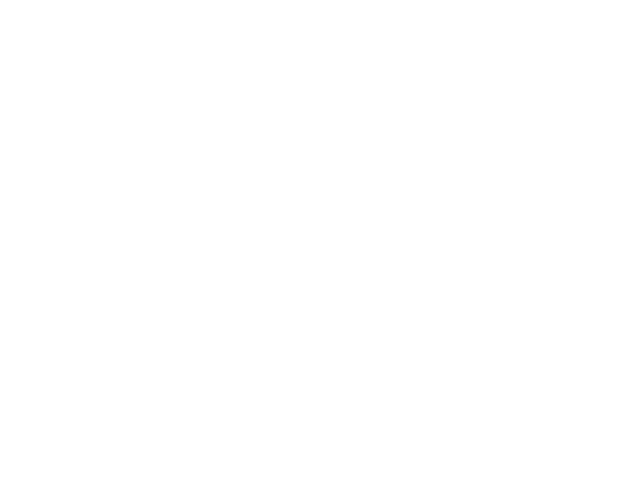

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [4]:
img = cv2.polylines(np.zeros((100, 100, 3)), reshaped_quads.astype(np.int),  
                      True, (255, 255, 255), 1) 
plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


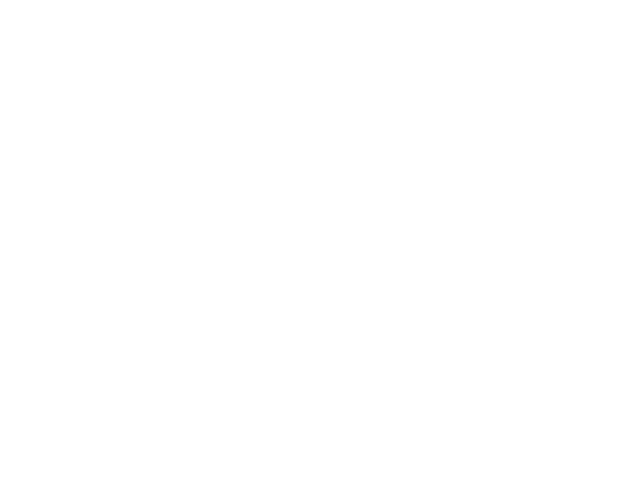

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [5]:
quads = np.array([[23, 23], [64, 14], [80, 92], [48, 91]], dtype=np.float)

reshaped_quads = quads.copy().reshape((-1, 4, 2))

shrinked_quads = shrink_quads_numpy(reshaped_quads, ref_lengths, 0.3)

img = cv2.polylines(np.zeros((100, 100, 3)), quads.reshape((-1, 4, 2)).astype(np.int),  
                      True, (255, 255, 255), 1) 
img = cv2.polylines(img, shrinked_quads.astype(np.int),  
                      True, (0, 255, 0), 1) 
plt.figure()
plt.imshow(img)

# create minimum rectangle surrounding quads points and angle

((52.03518295288086, 57.38251495361328), (41.97618103027344, 79.61656188964844), -12.380756378173828)
[[ 40.070366 100.76503 ]
 [ 23.000002  23.      ]
 [ 64.        14.      ]
 [ 81.070366  91.76503 ]]


<IPython.core.display.Javascript object>


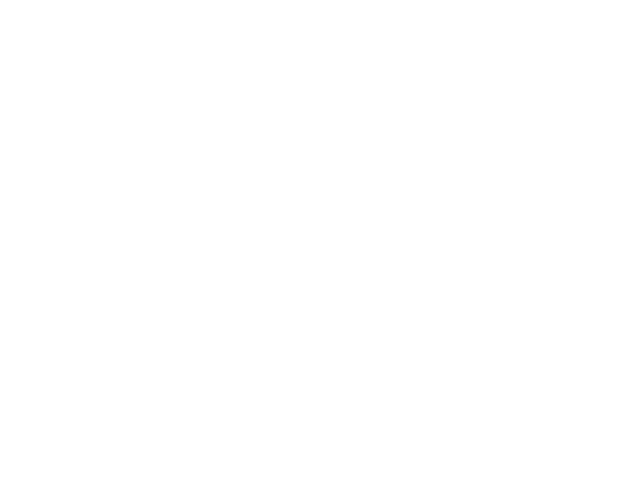

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [6]:
quads = np.array([[23, 23], [64, 14], [80, 92], [48, 91]], dtype=np.float)

rect = cv2.minAreaRect(quads.astype(np.int).reshape(-1, 4, 2))
box = cv2.boxPoints(rect)

print(rect)
print(box)

img = cv2.polylines(np.zeros((100, 100, 3)), quads.reshape((-1, 4, 2)).astype(np.int),  
                      True, (255, 255, 255), 1) 

img = cv2.polylines(img, box.reshape((-1, 4, 2)).astype(np.int),  
                      True, (255, 0, 0), 1) 

plt.figure()
plt.imshow(img)

# minAreaRect angle

<IPython.core.display.Javascript object>


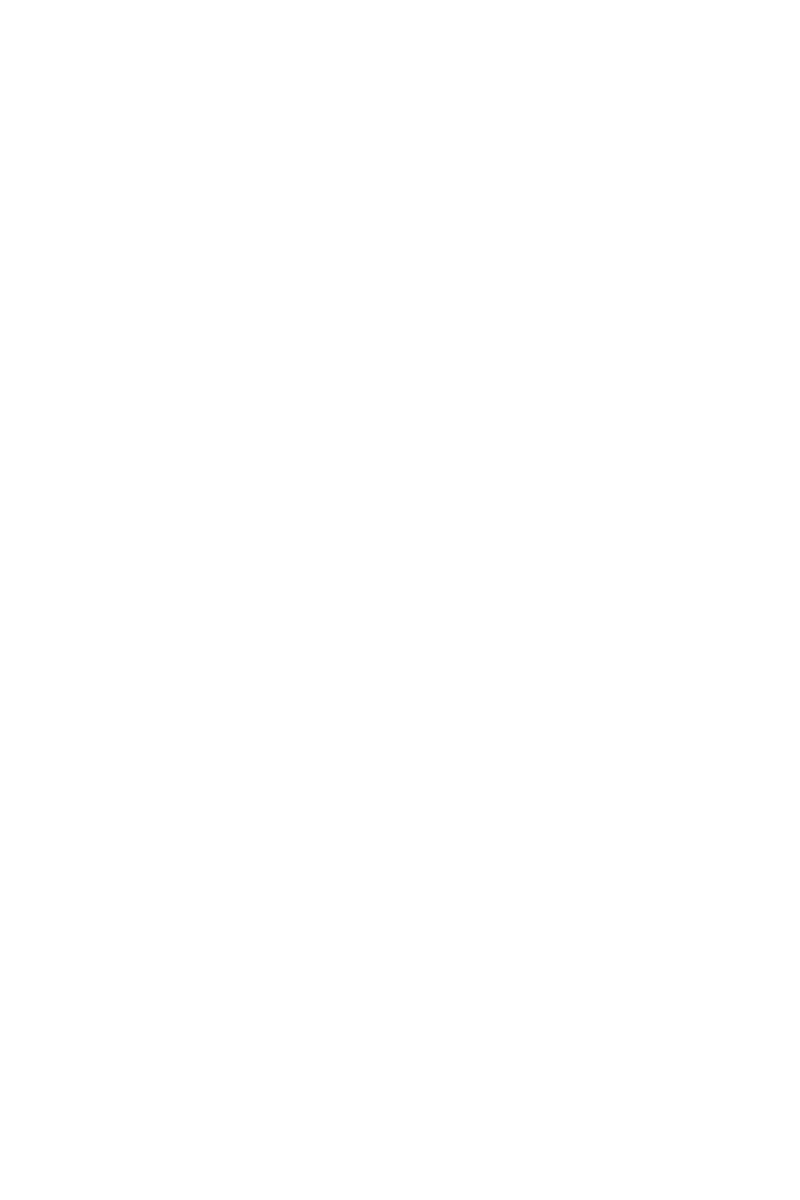

In [7]:
# ref: https://teratail.com/questions/228544
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 12))
fig.subplots_adjust(wspace=0.5)

for i, deg in enumerate(np.linspace(0, -360, 12, endpoint=False), 1):
    # 反時計回りに rad だけ回転させる回転行列を作成
    rad = np.radians(deg)
    R = np.array([[np.cos(rad), -np.sin(rad)],
                  [np.sin(rad), np.cos(rad)]], dtype=np.float32)
    # shape = (2=(x, y), 5)
    rect = np.array([[-1, -1.3], [-1, 1.3], [1, 1.3], [1, -1.3], [1, -1.3]], dtype=np.float32).T
    # shape = (2=(x, y), 2)
    line = np.array([[0, 0], [0, 1]], dtype=np.float32).T

    # rotate
    # shape = (2, 2=(x, y))
    line = (R @ line).T
    # shape = (5, 2=(x, y))
    rect = (R @ rect).T

    # minAreaRect が返す角度
    angle = cv2.minAreaRect(rect)[2]

    ax = fig.add_subplot(4, 3, i)
    ax.plot(line[:, 0], line[:, 1], "r")
    ax.add_patch(plt.Polygon(rect, color="b", fill=None, lw=2))
    ax.set_title(f"rot = {deg:.0f}, retval = {angle:.0f}")
    ax.set_aspect("equal")
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.8, 1.8)
    ax.grid()

plt.show()

# Check dataset

In [8]:
import sys
sys.path.append('../../')

from dl.data.txtdetn import datasets, target_transforms, transforms
%load_ext autoreload
%autoreload 2

In [9]:
augmentation = None

ignore = target_transforms.Ignore(strange=True)

transform = transforms.Compose(
    [#transforms.Resize((640, 640)),
     transforms.ToTensor(),]
     #transforms.Normalize(rgb_means=(0.485, 0.456, 0.406), rgb_stds=(0.229, 0.224, 0.225))]
)
target_transform = target_transforms.Compose(
    [target_transforms.Text2Number(class_labels=datasets.SynthText_char_labels_without_upper_blank, ignore_nolabel=False),
     target_transforms.ToTensor(textTensor=True)]
)

train_dataset = datasets.SynthTextDetectionDataset(ignore=ignore, transform=transform, target_transform=target_transform, augmentation=augmentation,
                                                   onlyAlphaNumeric=False)


In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2, torch

from dl.data.utils.converter import toVisualizeQuadsRGBimg, tensor2cvrgbimg
from dl.data.utils.boxes import quads2rboxes_numpy

time
you
played
so
fine
trw
apr


<IPython.core.display.Javascript object>


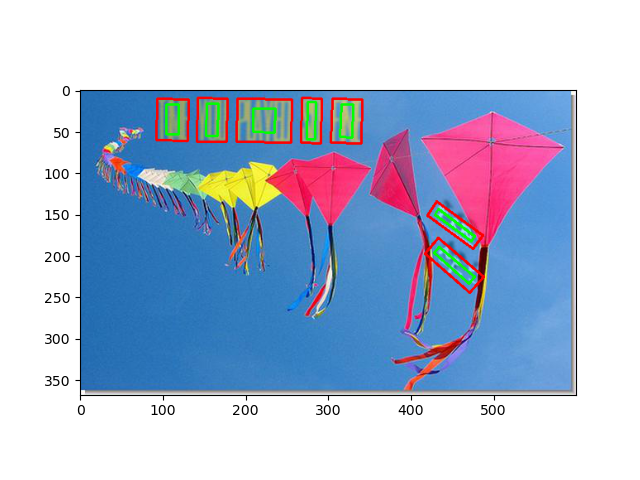

looked
pretty
good
there.
but
then
neither
used
to
seeing
for
both
make
dod
cap
key
and
the
newsgroups:


<IPython.core.display.Javascript object>


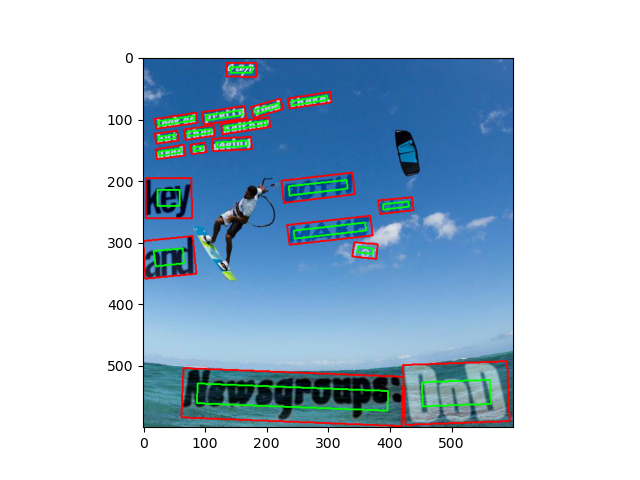

map.
mars
launched
will
martian
effects
nci
result
effects
of
the


<IPython.core.display.Javascript object>


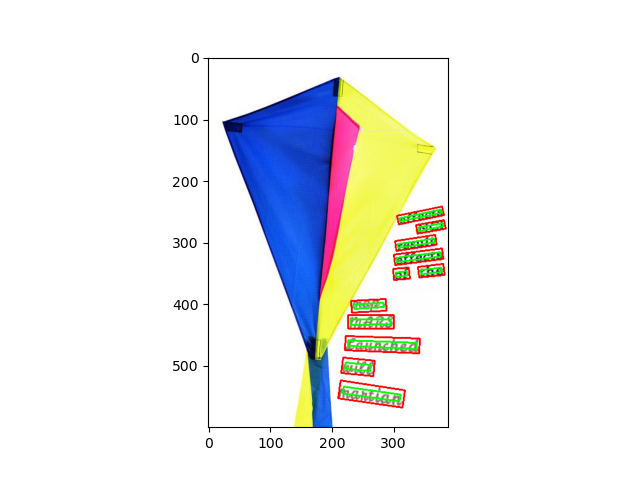

hill
(such
the


<IPython.core.display.Javascript object>


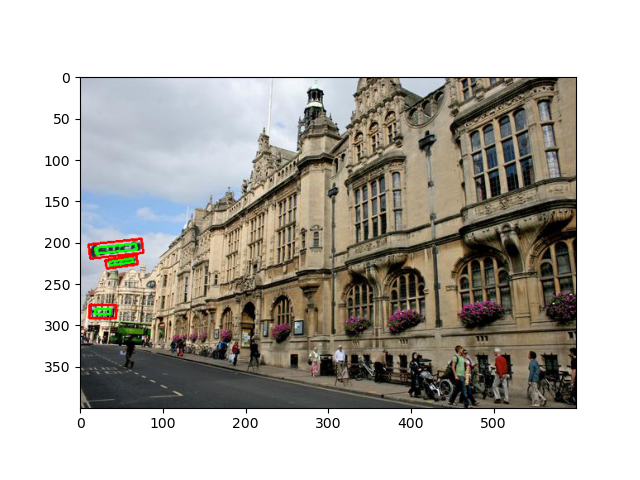

In [34]:
indices = [1, 100, 150, 10000]

for index in indices:
    img, targets, texts = train_dataset[index]
    
    for txt in texts:
        print(''.join([datasets.SynthText_char_labels_without_upper_blank[c.item()] for c in txt]))
    
    locs = targets[:, 4:12]

    img = toVisualizeQuadsRGBimg(img, locs.clone())#, , texts)
    
    rboxes = quads2rboxes_numpy(locs.numpy(), scale=0.3)
    shrinked_quads = torch.from_numpy(rboxes)[:, :8]

    img = toVisualizeQuadsRGBimg(torch.from_numpy(img.transpose((2,0,1))/255.), shrinked_quads, rgb=(0,255,0))
    
    plt.figure()
    plt.imshow(img)